# Programmatically load the data into your preferred analytical environment.


In [1]:
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define the file path
file_path = 'TRDataChallenge2023.txt'

# Initialize counters and storage
document_count = 0
postures_count = 0
paragraph_count = 0
data = []
unique_labels = set()  # Set to track unique labels

# Load and process each line as a separate JSON object
with open(file_path, 'r') as file:
    for line in file:
        # Parse each line as JSON
        document = json.loads(line.strip())
        
        # Increment document count
        document_count += 1
        
        # Count postures
        postures = document.get("postures", [])
        postures_count += len(postures)
        
        # Count paragraphs and aggregate text for model input
        document_text = ""
        for section in document.get("sections", []):
            paragraphs = section.get("paragraphs", [])
            paragraph_count += len(paragraphs)
            document_text += " ".join(paragraphs)  # Aggregate paragraphs into one string per document
        
        # Append data with document text and labels
        if postures:
            label = postures[0]  # Assuming first posture as label
            data.append((document_text, label))
            unique_labels.add(label)  # Add label to the set of unique labels

# Output data insights
print("Number of Documents:", document_count)
print("Number of Postures:", postures_count)
print("Number of Paragraphs:", paragraph_count)
print("Number of Unique Labels (Postures):", len(unique_labels))  # Count of unique labels

Number of Documents: 18000
Number of Postures: 27659
Number of Paragraphs: 542169
Number of Unique Labels (Postures): 194


# get unique label classes

In [2]:
NUM_CLASSES = len(unique_labels)
NUM_CLASSES

194

# Summarization frequency of labels

In [3]:
import pandas as pd
from collections import Counter 

# Calculate the distribution of each unique label
label_distribution = Counter(label for _, label in data)

# Create a DataFrame for better visualization
label_df = pd.DataFrame(label_distribution.items(), columns=['Label', 'Count'])
label_df = label_df.sort_values(by='Count', ascending=False).reset_index(drop=True)  # Sort by count

# Display the label distribution table
print("\nLabel Distribution (Sorted by Frequency):")
print(label_df)


Label Distribution (Sorted by Frequency):
                                             Label  Count
0                                        On Appeal   4942
1                                 Appellate Review   4652
2                                Motion to Dismiss   1449
3                Review of Administrative Decision   1395
4                       Motion for Attorney's Fees    609
..                                             ...    ...
189  Motion to Serve Additional Discovery Requests      1
190               Motion to Extend Claims Bar Date      1
191            Petition for Divorce or Dissolution      1
192        Declinatory Exception of Improper Venue      1
193              Motion to Vacate Summary Judgment      1

[194 rows x 2 columns]


- The top two labels, "On Appeal" (4942 instances) and "Appellate Review" (4652 instances), dominate the dataset. These labels represent common procedural postures in judicial opinions, which is expected given the nature of legal documents and the frequency of appeals in the legal process.

- Many labels (such as "Motion to Serve Additional Discovery Requests," "Petition for Divorce or Dissolution," and others) appear only once in the dataset. This indicates that these postures are rarely encountered, which poses challenges for any predictive modeling efforts.

- Challenges in Predicting Low-Frequency Labels: Predicting low-frequency labels presents several challenges: Insufficient Training Data, Models typically require a minimum number of examples to learn effectively. The imbalanced nature of the dataset can lead to model bias. For low-frequency labels, the model may memorize instances instead of generalizing patterns.

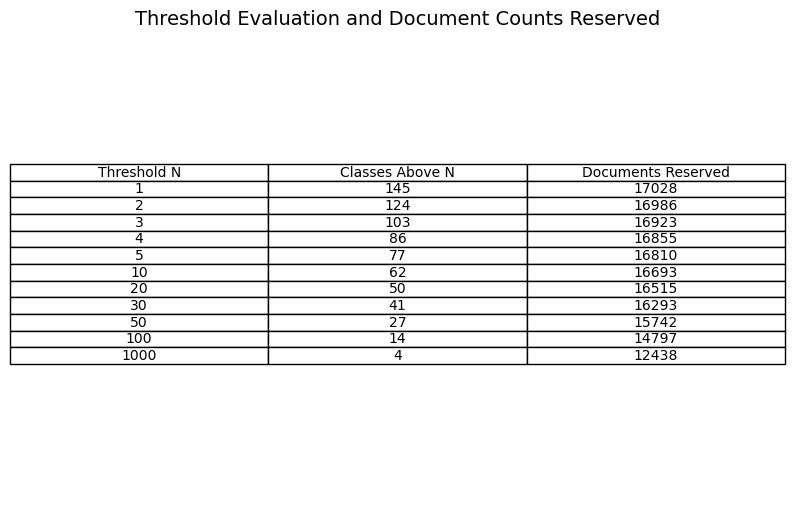

In [18]:
import json
import pandas as pd
from collections import Counter 
import matplotlib.pyplot as plt

# Assuming 'data' is already defined from previous processing
# Calculate the distribution of each unique label
label_distribution = Counter(label for _, label in data)

# Create a DataFrame for better visualization
label_df = pd.DataFrame(label_distribution.items(), columns=['Label', 'Count'])
label_df = label_df.sort_values(by='Count', ascending=False).reset_index(drop=True)  # Sort by count

# Evaluate counts above thresholds
thresholds = [1, 2, 3, 4, 6, 8, 10, 20, 30, 50, 100, 1000]
threshold_results = {n: (label_df['Count'] > n).sum() for n in thresholds}

# Calculate the number of documents reserved for each threshold
documents_reserved = {}
for n in thresholds:
    labels_above_threshold = label_df[label_df['Count'] > n]['Label']
    documents_reserved[n] = sum(1 for _, label in data if label in labels_above_threshold.values)

# Display threshold results in a DataFrame
threshold_df = pd.DataFrame(list(threshold_results.items()), columns=['Threshold N', 'Classes Above N'])
threshold_df['Documents Reserved'] = [documents_reserved[n] for n in thresholds]

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table_data = threshold_df.values
column_labels = threshold_df.columns

# Create a table plot
ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center')
plt.title('Threshold Evaluation and Document Counts Reserved', fontsize=14)
plt.show()

In [20]:
from collections import Counter

label_counts = Counter(label for _, label in data)
print("Label Distribution:", label_counts)

before_count = len(data)
print("Count before removing labels with fewer than {min_instances} instances:", before_count)

min_instances = 5
filtered_data = [(text, label) for text, label in data if label_counts[label] >= min_instances]

after_count = len(filtered_data)
print("Count after removing labels with fewer than {min_instances} instances:", after_count)

Label Distribution: Counter({'On Appeal': 4942, 'Appellate Review': 4652, 'Motion to Dismiss': 1449, 'Review of Administrative Decision': 1395, "Motion for Attorney's Fees": 609, 'Motion for Preliminary Injunction': 340, 'Motion to Dismiss for Lack of Subject Matter Jurisdiction': 287, 'Motion to Compel Arbitration': 244, 'Motion for Judgment as a Matter of Law (JMOL)/Directed Verdict': 193, 'Motion for Reconsideration': 164, 'Motion to Dismiss for Lack of Personal Jurisdiction': 156, 'Motion for Default Judgment/Order of Default': 132, 'Motion for New Trial': 127, 'Motion to Dismiss for Lack of Standing': 107, 'Motion for Protective Order': 100, 'Motion for Permanent Injunction': 95, 'Motion for Contempt': 94, 'Motion to Dismiss for Lack of Jurisdiction': 93, 'Motion to Transfer or Change Venue': 76, 'Motion to Set Aside or Vacate': 74, 'Certified Question': 72, 'Sentencing or Penalty Phase Motion or Objection': 67, 'Motion for Costs': 57, 'Motion for Sanctions (Discovery)': 57, 'Moti

# train test split, load data and load model (legal bert)

LEGAL-BERT is a family of BERT models for the legal domain, intended to assist legal NLP research, computational law, and legal technology applications. https://huggingface.co/nlpaueb/legal-bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Custom Dataset Class for BERT Fine-Tuning

In [22]:
# Step 2: Custom Dataset Class for BERT Fine-Tuning
class LegalDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def posture_to_label(self, postures):
        # Convert postures to a multi-label vector
        label = [0] * NUM_CLASSES
        for posture in postures:
            if posture in POSTURE_MAPPING:
                label[POSTURE_MAPPING[posture]] = 1
        return label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        encoding = self.tokenizer(
            sample["text"], 
            truncation=True, 
            padding="max_length", 
            max_length=self.max_length, 
            return_tensors="pt"
        )
        label = self.posture_to_label(sample["postures"])
        encoding["labels"] = torch.tensor(label, dtype=torch.float)
        return {key: val.squeeze() for key, val in encoding.items()}

# Load train and validation datasets
train_dataset = LegalDataset(train_data, tokenizer=tokenizer)
val_dataset = LegalDataset(val_data, tokenizer=tokenizer)

# start training

In [23]:
import torch
from transformers import Trainer, TrainingArguments

# Empty GPU cache before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Step 1: Define the total number of steps
# For example, if you want to train for 500 steps
total_steps = 200  # Adjust this based on your requirements

# Step 2: Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",  # Change to steps
    eval_steps=100,  # Evaluate every 100 steps
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=0,  # Set to 0 since we are using steps
    max_steps=total_steps,  # Set max_steps instead of num_train_epochs
    weight_decay=0.01,
    logging_dir='./logs',
)

# Step 3: Set up the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Step 4: Train and Evaluate the Model
trainer.train()
trainer.evaluate()

# Step 5: Save the Trained Model
model.save_pretrained("./legalbert_procedural_postures")
tokenizer.save_pretrained("./legalbert_procedural_postures")

/work/van-speech-nlp/jindaznb/slamenv/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jindaz (jindaz-work). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


KeyboardInterrupt: 